## 0. Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

import torch
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from model import AutoEncoder, ClassificationModel

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Check CUDA
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

---
## 1. Load and prepare the data

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)
train_dataset, valid_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

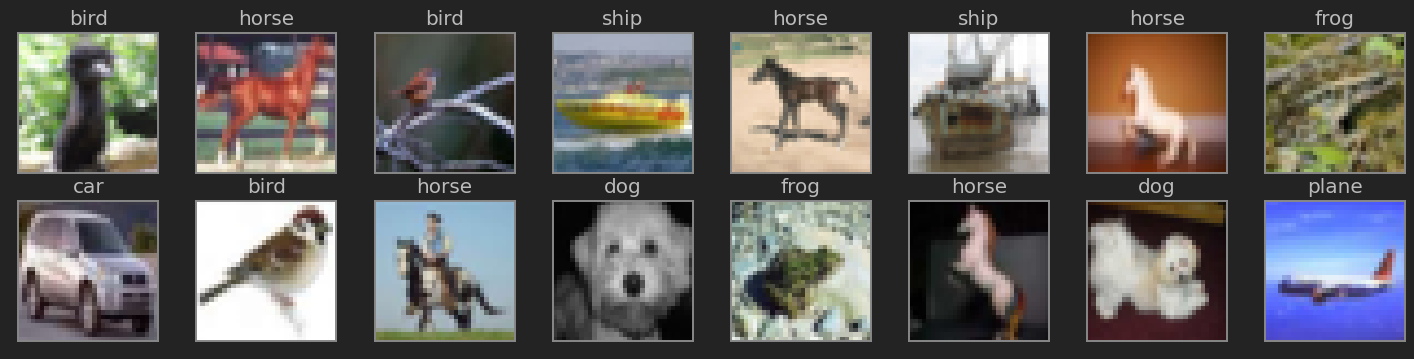

In [3]:
labels_dict = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)), cmap='Greys')
plt.show()

---
## 2. Load and run the autoencoder model with different hidden state size

In [4]:
model = AutoEncoder(hidden_dim=128).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
       BatchNorm2d-3           [-1, 32, 28, 28]              64
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 64, 26, 26]          18,496
            Conv2d-6           [-1, 64, 24, 24]          36,928
       BatchNorm2d-7           [-1, 64, 24, 24]             128
              ReLU-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 22, 22]          73,856
           Conv2d-10          [-1, 128, 20, 20]         147,584
      BatchNorm2d-11          [-1, 128, 20, 20]             256
             ReLU-12          [-1, 128, 20, 20]               0
          Flatten-13                [-1, 51200]               0
             ReLU-14                [-1

In [5]:
def enc_model_run(model, data_loader, stage, device=torch.device('cpu'), clear_memory=True):
    '''
    Function of run the model with data loader generator
    '''
    loss_cum = 0.
    for inputs, _ in data_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss_cum += loss.item()
        
        if stage=='train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if clear_memory:
            del inputs
            gc.collect()
            torch.cuda.empty_cache()
        
    return loss_cum / len(data_loader)

In [8]:
%%time
hidden_dimensions = [512, 256, 128, 64, 32, 16]

for HIDDEN_DIMENSION in hidden_dimensions:
    history = pd.DataFrame(columns=['hidden_dimension', 'epoch', 'train_loss', 'valid_loss'])
    enc_model = AutoEncoder(hidden_dim=HIDDEN_DIMENSION).to(device)
    optimizer = torch.optim.Adam(enc_model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    min_loss = float('inf')

    print(f'Start training with {HIDDEN_DIMENSION}-sized hidden dimension')
    for epoch in range(81):  
        for stage in ['train', 'eval']:
            # TRAIN
            if stage=='train':
                enc_model.train()
                loss_train = enc_model_run(enc_model, train_loader, stage, device)
            # EVALUATION
            elif stage=='eval':
                enc_model.eval()
                with torch.no_grad():
                    loss_valid = enc_model_run(enc_model, valid_loader, stage, device)

        history.loc[len(history)] = [HIDDEN_DIMENSION, epoch, loss_train , loss_valid]
        
        # Save the best model (relying on valid loss)
        if loss_valid < min_loss:
            min_loss = loss_valid
            torch.save(enc_model.state_dict(), f'./Models/model_{HIDDEN_DIMENSION}-hidden_dim.pth')

        if (epoch % 10 == 0):
            print(f"Epoch: {epoch}, train_loss: {loss_train}, valid_loss: {loss_valid}")

    history.to_csv(f'./History/history_{HIDDEN_DIMENSION}-hidden_dim.csv')
    print(f'Training with {HIDDEN_DIMENSION}-sized hidden dimension is finished!')
    print('=' * 80)

Start training with 512-sized hidden dimension
Epoch: 0, train_loss: 0.07955570307997417, valid_loss: 0.049124578945338726
Epoch: 10, train_loss: 0.009302087551058859, valid_loss: 0.010965509619563819
Epoch: 20, train_loss: 0.00560161861001837, valid_loss: 0.005566040216945112
Epoch: 30, train_loss: 0.012835861673122463, valid_loss: 0.010353671014308929
Epoch: 40, train_loss: 0.005007636548038952, valid_loss: 0.00487867712508887
Epoch: 50, train_loss: 0.004271942746768497, valid_loss: 0.00427935051266104
Epoch: 60, train_loss: 0.0035097161010953083, valid_loss: 0.0036073718802072108
Epoch: 70, train_loss: 0.002899284586215354, valid_loss: 0.0039974097104277465
Epoch: 80, train_loss: 0.0025356590964033137, valid_loss: 0.003936124587198719
Training with 512-sized hidden dimension is finished!
Start training with 256-sized hidden dimension
Epoch: 0, train_loss: 0.06605303108844222, valid_loss: 0.04277548147365451
Epoch: 10, train_loss: 0.011957660037073858, valid_loss: 0.00989762893877923

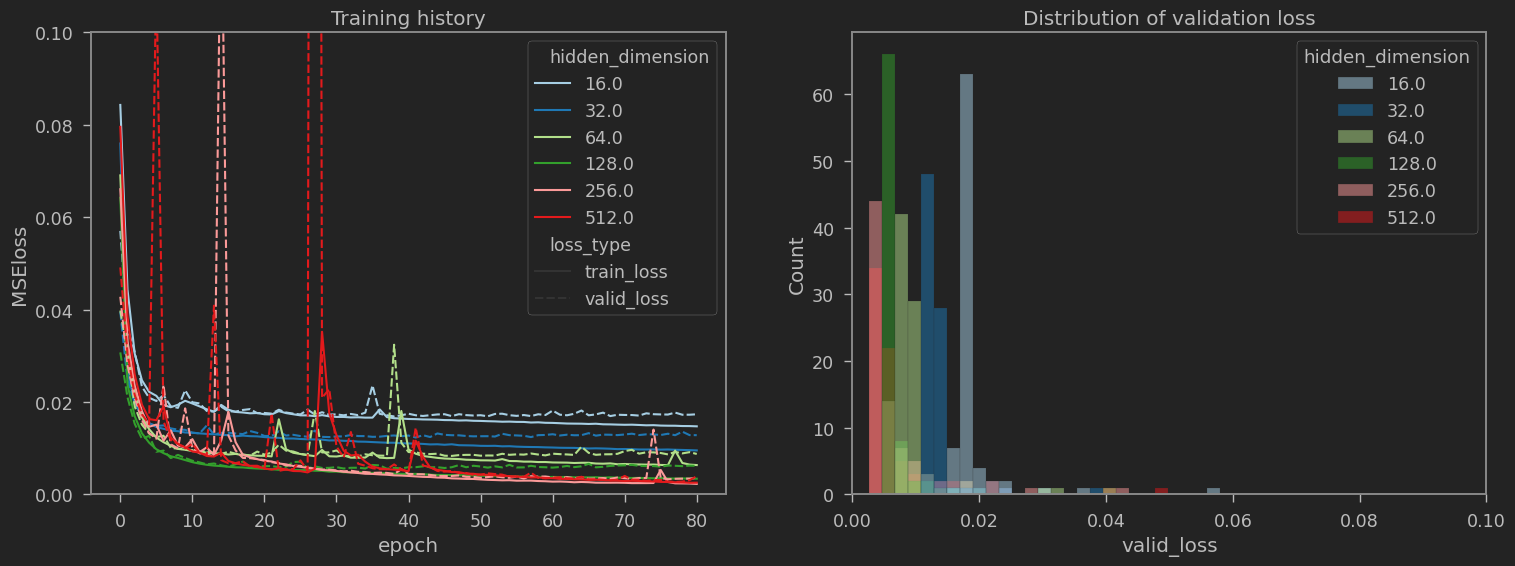

In [4]:
# Plot full history
history = pd.DataFrame()
for path in glob.glob('./History/history_*.csv'):
    history = pd.concat([history, pd.read_csv(path, index_col=0, dtype={'train_loss': 'float64', 'valid_loss': 'float64'})], axis=0)
    
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.lineplot(data=history.melt(id_vars=['hidden_dimension', 'epoch'], 
                               value_vars=['train_loss', 'valid_loss'], 
                               var_name='loss_type',
                               value_name='MSEloss'),
             x='epoch', 
             y='MSEloss',
             hue='hidden_dimension', 
             style='loss_type',
             palette='Paired',
            )
plt.title('Training history')
plt.ylim([0, 0.1])
plt.subplot(122)
sns.histplot(data=history, x='valid_loss', hue='hidden_dimension', palette='Paired')
plt.title('Distribution of validation loss')
plt.xlim([0, 0.1])
plt.show()

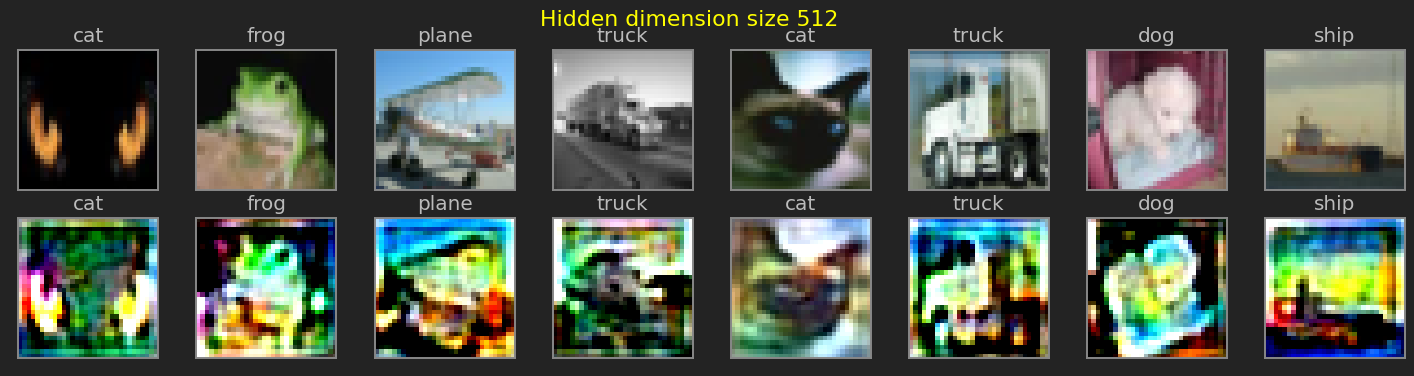

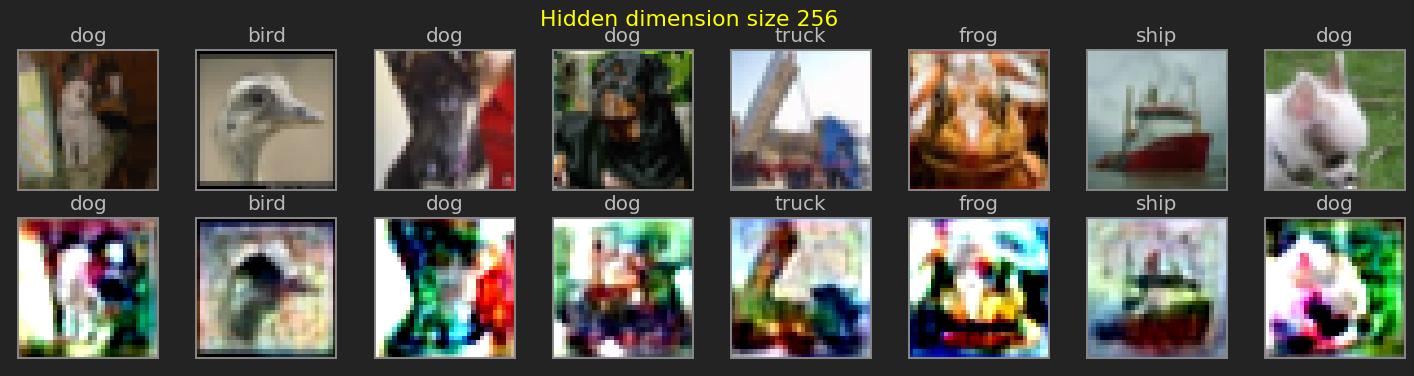

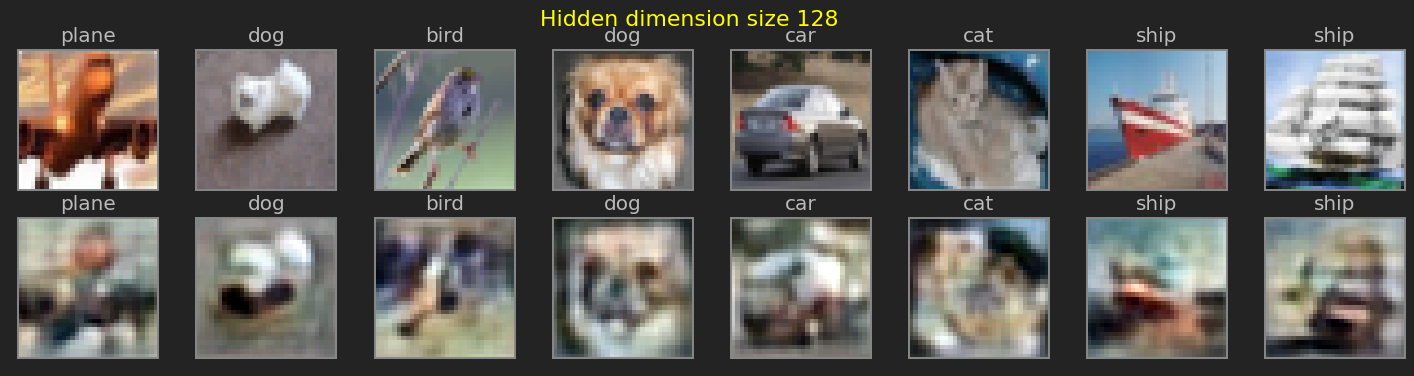

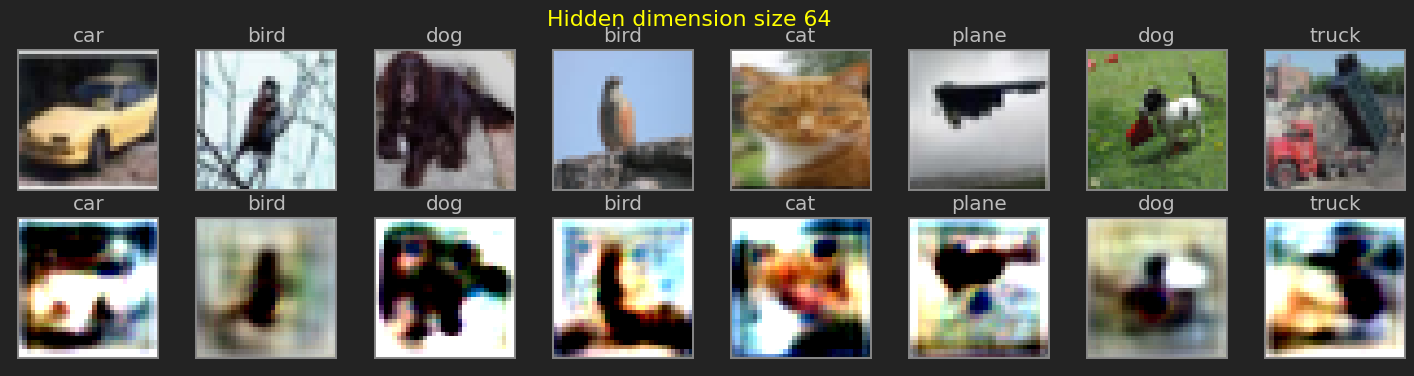

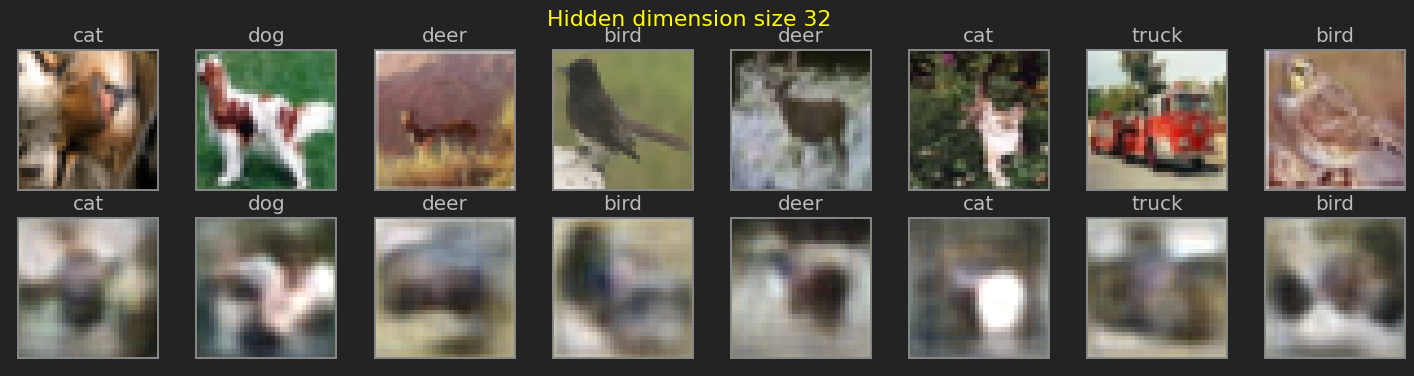

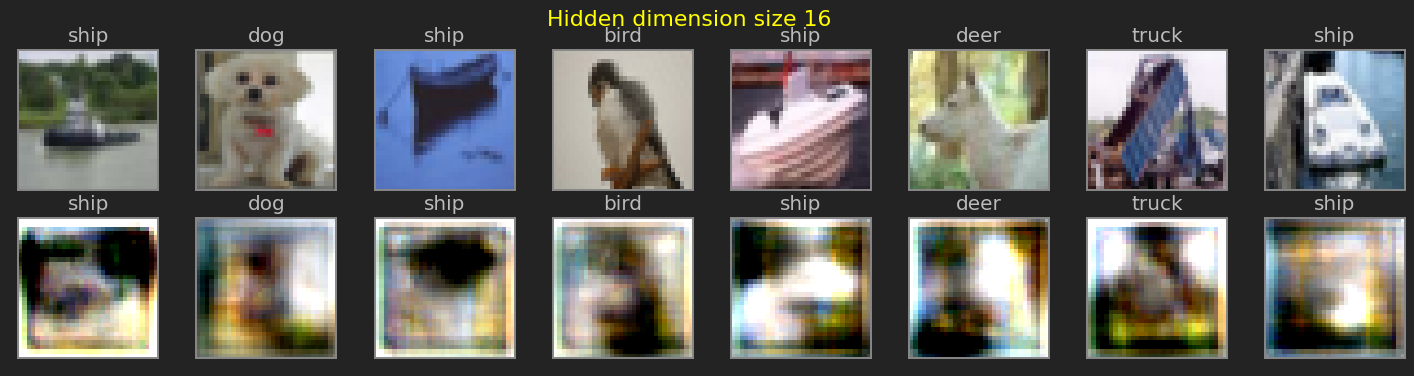

In [14]:
device = torch.device('cpu')
for chosen_dim in [512, 256, 128, 64, 32, 16]:
    model = AutoEncoder(hidden_dim=chosen_dim)
    model.load_state_dict(torch.load(f'./Models/model_{chosen_dim}-hidden_dim.pth', map_location=device))

    figure = plt.figure(figsize=(18, 4))
    cols, rows = 8, 2
    for i in range(1, cols + 1):
        sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
        img, label = valid_dataset[sample_idx]
        prediction = model(img[None, :, :, :]).detach().numpy()[0]
        prediction[prediction > 1.] = 1.
        
        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(img, axes=(1, 2, 0)))

        figure.add_subplot(rows, cols, i+8)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(prediction, axes=(1, 2, 0)))
    
    plt.suptitle(f'Hidden dimension size {chosen_dim}', color='yellow')
    plt.show()

---
## 3.  Load and train classification model

In [5]:
# Let's take the model with 128-dimensioned hidden state, that looks enough for the task
chosen_dim = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(hidden_dim=chosen_dim)
model.load_state_dict(torch.load(f'./Models/model_{chosen_dim}-hidden_dim.pth', map_location=device))

# Fix encoder weights
pretrained_encoder = model.enc
for param in pretrained_encoder.parameters():
    param.requires_grad = False
pretrained_encoder

Encoder(
  (conv_1st): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2nd): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_3rd): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_4th): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_5th): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv_6th): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=51200, out_features=128, bias=True)
  (batch_norm_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)

In [7]:
clas_model = ClassificationModel(input_dim=chosen_dim, pretrained_encoder=pretrained_encoder).to(device)
summary(clas_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
            Conv2d-2           [-1, 32, 28, 28]           9,248
       BatchNorm2d-3           [-1, 32, 28, 28]              64
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 64, 26, 26]          18,496
            Conv2d-6           [-1, 64, 24, 24]          36,928
       BatchNorm2d-7           [-1, 64, 24, 24]             128
              ReLU-8           [-1, 64, 24, 24]               0
            Conv2d-9          [-1, 128, 22, 22]          73,856
           Conv2d-10          [-1, 128, 20, 20]         147,584
      BatchNorm2d-11          [-1, 128, 20, 20]             256
             ReLU-12          [-1, 128, 20, 20]               0
          Flatten-13                [-1, 51200]               0
             ReLU-14                [-1

In [8]:
optimizer = torch.optim.Adam(clas_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
min_loss = float('inf')

for epoch in range(31):  
    # TRAIN BLOCK
    clas_model.train()
    loss_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = clas_model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        del inputs, labels
        gc.collect()
        torch.cuda.empty_cache()

    # EVAL BLOCK
    clas_model.eval()
    loss_valid = 0.
    accuracy = 0.
    total = 0.
    with torch.no_grad():
        for X, y in valid_loader:
            output = clas_model(X.to(device))
            loss = criterion(output, y.to(device))
            loss_valid += loss.item()
            
            y_pred_softmax = torch.log_softmax(clas_model(X.to(device)), dim=1)
            _, predicted = torch.max(y_pred_softmax.data, dim=1)
            total += y.size(0)
            accuracy += (predicted == y.to(device)).sum().item()

            del X, y
            gc.collect()
            torch.cuda.empty_cache()
            
    # Save the best model (relying on valid loss)
    if loss_valid < min_loss:
        min_loss = loss_valid
        torch.save(clas_model.state_dict(), './Models/classification_model.pth')   
            
    if (epoch % 5 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}, valid Accuracy: {(100 * accuracy / total)}%")

print(f'Training is finished!')

Epoch: 0, train_loss: 2.467252719159029, valid_loss: 1.481292486190796, valid Accuracy: 47.44%
Epoch: 5, train_loss: 0.6967221705281005, valid_loss: 1.5951742231845856, valid Accuracy: 51.95%
Epoch: 10, train_loss: 0.22382676449357247, valid_loss: 2.5676767468452453, valid Accuracy: 50.68%
Epoch: 15, train_loss: 0.13908690018389297, valid_loss: 3.4207786440849306, valid Accuracy: 51.14%
Epoch: 20, train_loss: 0.14064449210632213, valid_loss: 3.9027629256248475, valid Accuracy: 51.48%
Epoch: 25, train_loss: 0.13132621066606776, valid_loss: 4.319623386859893, valid Accuracy: 51.5%
Epoch: 30, train_loss: 0.10984816355630755, valid_loss: 4.9310696721076965, valid Accuracy: 50.5%
Training is finished!


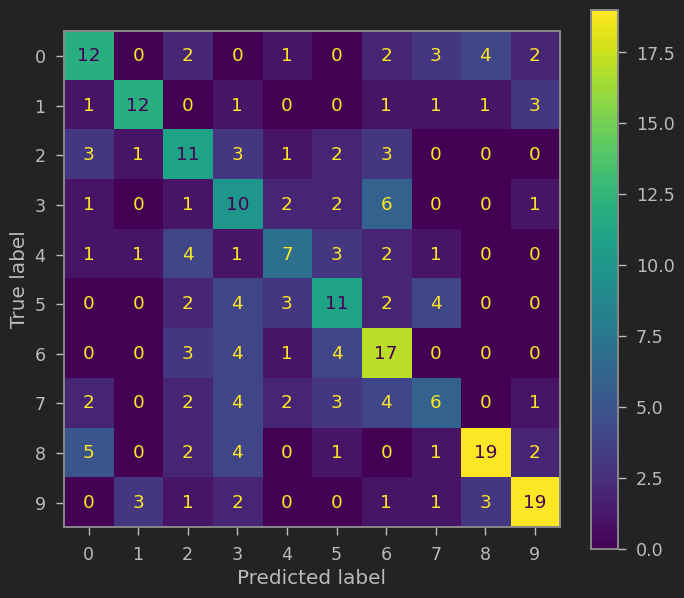

In [12]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

clas_model = ClassificationModel(input_dim=chosen_dim, pretrained_encoder=pretrained_encoder).to(device)
clas_model.load_state_dict(torch.load(f'./Models/classification_model.pth', map_location=device))
_, predicted = torch.max(clas_model(x).data, 1)

cm = confusion_matrix(y, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()